<a href="https://colab.research.google.com/github/mahausmani/EXIST-2024-LLM-Project/blob/mr/TASK2_EXIST2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Tasks 3 of EXIST 2024


# Imports and setup


In [13]:
!pip install datasets

In [14]:
! pip install -U accelerate
! pip install -U transformers

In [15]:
import os
import shutil
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score
!pip install scipy

In [16]:
import gdown
import pandas as pd

# URLs of the datasets
dev_url = 'https://drive.google.com/uc?id=1SnCAPwCLKqgBQ5MJ01hX1sBwXXz0UpUQ'
test_url = 'https://drive.google.com/uc?id=1v6C__BiKOnzPuiMKjD_QBpKSsRgETlxg'
train_url = 'https://drive.google.com/uc?id=1BBBNaXyzlQq0CsNQocmsNMT1c58mwhYj'

# Downloading the datasets
gdown.download(dev_url, 'dev.json', quiet=False)
gdown.download(test_url, 'test.json', quiet=False)
gdown.download(train_url, 'train.json', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1SnCAPwCLKqgBQ5MJ01hX1sBwXXz0UpUQ
To: /content/dev.json
100%|██████████| 1.42M/1.42M [00:00<00:00, 102MB/s]
Downloading...
From: https://drive.google.com/uc?id=1v6C__BiKOnzPuiMKjD_QBpKSsRgETlxg
To: /content/test.json
100%|██████████| 2.14M/2.14M [00:00<00:00, 211MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BBBNaXyzlQq0CsNQocmsNMT1c58mwhYj
To: /content/train.json
100%|██████████| 9.40M/9.40M [00:00<00:00, 49.2MB/s]


'train.json'

# Loading the Training Dataset


In [17]:
train_df = pd.read_json('train.json',orient='index')
required_columns = ["id_EXIST", "lang", "tweet","labels_task1","labels_task2","labels_task3","split"]
train_df = train_df[required_columns]
train_df.head()

,id_EXIST,lang,tweet,labels_task1,labels_task2,labels_task3,split
100001,100001,es,"@TheChiflis Ignora al otro, es un capullo.El p...","[YES, YES, NO, YES, YES, YES]","[REPORTED, JUDGEMENTAL, -, REPORTED, JUDGEMENT...","[[OBJECTIFICATION], [OBJECTIFICATION, SEXUAL-V...",TRAIN_ES
100002,100002,es,@ultimonomada_ Si comicsgate se parece en algo...,"[NO, NO, NO, NO, YES, NO]","[-, -, -, -, DIRECT, -]","[[-], [-], [-], [-], [OBJECTIFICATION], [-]]",TRAIN_ES
100003,100003,es,"@Steven2897 Lee sobre Gamergate, y como eso ha...","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",TRAIN_ES
100004,100004,es,@Lunariita7 Un retraso social bastante lamenta...,"[NO, NO, YES, NO, YES, YES]","[-, -, DIRECT, -, REPORTED, REPORTED]","[[-], [-], [IDEOLOGICAL-INEQUALITY], [-], [IDE...",TRAIN_ES
100005,100005,es,@novadragon21 @icep4ck @TvDannyZ Entonces como...,"[YES, NO, YES, NO, YES, YES]","[REPORTED, -, JUDGEMENTAL, -, JUDGEMENTAL, DIR...","[[STEREOTYPING-DOMINANCE, OBJECTIFICATION], [-...",TRAIN_ES


# Loading the Validation Dataset

In [18]:
df_val = pd.read_json('/content/dev.json',orient='index')
df_val = df_val[required_columns]
df_val.head()

,id_EXIST,lang,tweet,labels_task1,labels_task2,labels_task3,split
300001,300001,es,@Fichinescu La comunidad gamer es un antro de ...,"[NO, YES, YES, NO, YES, NO]","[-, JUDGEMENTAL, JUDGEMENTAL, -, REPORTED, -]","[[-], [MISOGYNY-NON-SEXUAL-VIOLENCE], [MISOGYN...",DEV_ES
300002,300002,es,@anacaotica88 @MordorLivin No me acuerdo de lo...,"[YES, YES, NO, YES, YES, YES]","[JUDGEMENTAL, REPORTED, -, JUDGEMENTAL, JUDGEM...","[[IDEOLOGICAL-INEQUALITY, STEREOTYPING-DOMINAN...",DEV_ES
300003,300003,es,@cosmicJunkBot lo digo cada pocos dias y lo re...,"[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",DEV_ES
300004,300004,es,Also mientras les decia eso la señalaba y deci...,"[NO, YES, YES, YES, YES, YES]","[-, REPORTED, REPORTED, REPORTED, JUDGEMENTAL,...","[[-], [SEXUAL-VIOLENCE], [SEXUAL-VIOLENCE], [S...",DEV_ES
300005,300005,es,"And all people killed, attacked, harassed by ...","[NO, YES, NO, NO, NO, NO]","[-, DIRECT, -, -, -, -]","[[-], [STEREOTYPING-DOMINANCE], [-], [-], [-],...",DEV_ES


# Loading Test Dataset


In [19]:
df_test = pd.read_json('/content/test.json',orient='index')
df_test.head()

,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,ethnicities_annotators,study_levels_annotators,countries_annotators,split
500001,500001,es,@Eurogamer_es Todo gamergate desde el desarrol...,6,"[Annotator_810, Annotator_811, Annotator_812, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[Hispano or Latino, White or Caucasian, White ...","[High school degree or equivalent, Master’s de...","[Mexico, Spain, Italy, United States, Portugal...",TEST_ES
500002,500002,es,"@ArCaNgEl__23 @Benzenazi Hombre, no es compara...",6,"[Annotator_780, Annotator_816, Annotator_817, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[Hispano or Latino, Hispano or Latino, Black o...","[High school degree or equivalent, Bachelor’s ...","[Chile, Mexico, United States, Mexico, Mexico,...",TEST_ES
500003,500003,es,yo buscando las empresas metidas en el gamerga...,6,"[Annotator_821, Annotator_822, Annotator_823, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[Hispano or Latino, Hispano or Latino, Asian, ...","[Bachelor’s degree, Bachelor’s degree, Master’...","[Mexico, Mexico, VietNam, United States, Mexic...",TEST_ES
500004,500004,es,"@jordirico Primero fue internet, luego el game...",6,"[Annotator_827, Annotator_828, Annotator_829, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[Hispano or Latino, White or Caucasian, Hispan...","[High school degree or equivalent, Bachelor’s ...","[Chile, Spain, Mexico, United Kingdom, Chile, ...",TEST_ES
500005,500005,es,@AlonsoQuijano12 Yo estuve metido en el gamerg...,6,"[Annotator_827, Annotator_828, Annotator_829, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[Hispano or Latino, White or Caucasian, Hispan...","[High school degree or equivalent, Bachelor’s ...","[Chile, Spain, Mexico, United Kingdom, Chile, ...",TEST_ES


# Preproccessing the Dataset


In [20]:
def assign_majority_label(labels, num_annotators):
    if num_annotators == 1:labels = np.concatenate(labels)
    else:labels = np.array(labels).flatten()
    counts = pd.Series(labels).value_counts()
    filtered_counts = counts[counts > num_annotators]
    if len(filtered_counts.index) == 1:
        return filtered_counts.index[0]
    elif len(filtered_counts.index) > 1:
        return filtered_counts.index.tolist()
    else:
        return None



In [21]:
def transform3(x):
    out = []
    if x:
      for i in x:
        if i=='IDEOLOGICAL-INEQUALITY':
          out.append(1)
        elif i=='MISOGYNY-NON-SEXUAL-VIOLENCE':
          out.append(2)
        elif i=='OBJECTIFICATION':
          out.append(3)
        elif i=='STEREOTYPING-DOMINANCE':
          out.append(4)
        elif i=='SEXUAL-VIOLENCE':
          out.append(5)
        # elif i=="-":
        #   out.append(6)
        else :
          out.append(0)
    return out

labels3 = ['IDEOLOGICAL-INEQUALITY','MISOGYNY-NON-SEXUAL-VIOLENCE', 'OBJECTIFICATION','STEREOTYPING-DOMINANCE','SEXUAL-VIOLENCE','NO']
def softmax(label_counts):
    labels = list(label_counts.values())
    probabilities = np.exp(labels)/np.sum(np.exp(labels))
    return probabilities
def calculate_soft_labels_3(labels):
    d = {label: 0 for label in labels3}
    for label in labels:
        for j in label:
            if j =='-' or j =="UNKNOWN":j = 'NO'
            d[j] = d.get(j,0) + 1
    return softmax(d)

In [22]:
train_df["soft_label3"] = train_df["labels_task3"].apply(calculate_soft_labels_3)
train_df["hard_label3"] = train_df["labels_task3"].apply(lambda x: assign_majority_label(x, 1))
train_df["hard_label3"] = train_df["hard_label3"].apply(transform3)

df_val["soft_label3"] = df_val["labels_task3"].apply(calculate_soft_labels_3)
df_val["hard_label3"] = df_val["labels_task3"].apply(lambda x: assign_majority_label(x, 1))
df_val["hard_label3"] = df_val["hard_label3"].apply(transform3)

train_dataset_soft3 = train_df[["tweet", "soft_label3"]]
train_dataset_hard3 = train_df[["tweet", "hard_label3"]]

val_dataset_soft3 = df_val[["tweet", "soft_label3"]]
val_dataset_hard3 = df_val[["tweet", "hard_label3"]]

test_dataset3 = df_test[["tweet"]]

In [23]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [24]:
train_df["tweet"] = train_df["tweet"].apply(preprocess)
df_val["tweet"] = df_val["tweet"].apply(preprocess)
df_test["tweet"] = df_test["tweet"].apply(preprocess)

# Task 3

# BERT
Don't run this section

### Model loading

In [25]:
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
model_chkpt = "/content/drive/MyDrive/chkpt/checkpoint-2595"
model_name = "bert-base-multilingual-uncased"
model = BertForSequenceClassification.from_pretrained(model_name, num_labels = 6)
tokenizer = BertTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

### Tokenization

In [26]:
from datasets import Dataset

In [27]:
def tokenize_function(example):
    return tokenizer(
        example["tweet"],
        max_length=512,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )

In [28]:
tokenized_train = Dataset.from_pandas(train_dataset_soft3).map(tokenize_function, batched=True)
tokenized_validation = Dataset.from_pandas(val_dataset_soft3).map(tokenize_function, batched=True)
tokenized_test = Dataset.from_pandas(test_dataset3).map(tokenize_function, batched=True)

Map:   0%|          | 0/6920 [00:00<?, ? examples/s]

Map:   0%|          | 0/1038 [00:00<?, ? examples/s]

Map:   0%|          | 0/2076 [00:00<?, ? examples/s]

In [29]:
tokenized_datasets = tokenized_train.rename_column("soft_label3", "labels")
tokenized_datasets_train = tokenized_datasets.remove_columns(["tweet", "__index_level_0__"])
tokenized_datasets_train.set_format("torch")


tokenized_datasets = tokenized_validation.rename_column("soft_label3", "labels")
tokenized_datasets_val = tokenized_datasets.remove_columns(["tweet"])
tokenized_datasets_val.set_format("torch")

tokenized_datasets_test = tokenized_test.remove_columns(["tweet"])
tokenized_datasets_test.set_format("torch")

### Training the dataset

In [30]:
!mkdir "/content/checkpoints3"
!mkdir "/content/checkpoints3/bert"
!mkdir "/content/checkpoints3/xlm"

!mkdir "/content/outputs3"
!mkdir "/content/outputs3/bert"
!mkdir "/content/outputs3/xlm"
!mkdir "/content/outputs3/ensamble"

!mkdir "/content/output/"

In [31]:
epochs = 5

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
from transformers import Trainer
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.cuda.empty_cache()

training_args = TrainingArguments(
    output_dir="/content/chkpt",
    num_train_epochs=epochs,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-05,
    weight_decay=0.004891290652279793,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch"
)

#with cross entropy loss and label smoothing
def custom_loss_fn(logits, soft_labels3):
    probs = torch.sigmoid(logits)
    # Apply nn.CrossEntropyLoss
    loss = nn.CrossEntropyLoss(reduction="sum",label_smoothing=0.15)(probs, soft_labels3)
    return loss

# Define the trainer for each fold
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = custom_loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss



torch.cuda.empty_cache()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets_train,
    eval_dataset= tokenized_datasets_val
)



In [33]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,12.258500,12.315103
2,12.055400,12.178041
3,11.904700,12.124565
4,11.744100,12.108740
5,11.643500,12.111515


TrainOutput(global_step=4325, training_loss=11.921243226156069, metrics={'train_runtime': 3372.4959, 'train_samples_per_second': 10.259, 'train_steps_per_second': 1.282, 'total_flos': 9103969467187200.0, 'train_loss': 11.921243226156069, 'epoch': 5.0})

### Predictions for BERT


In [34]:
from scipy.special import expit
val_predictions = trainer.predict(tokenized_datasets_val)
val_pred_probabilities = expit(val_predictions.predictions)

val_pred_labels = np.where(val_pred_probabilities > 0.5, 1, 0)
val_true_labels = [[1 if value > 0.5 else 0 for value in sublist] for sublist in tokenized_datasets_val["labels"]]

from sklearn.metrics import accuracy_score, f1_score
# Calculate evaluation metrics
val_accuracy = accuracy_score(val_true_labels, val_pred_labels)
val_f1_score = f1_score(val_true_labels, val_pred_labels,average = "weighted")

In [35]:
print("accuracy of bert",val_accuracy)
print("f1 score of bert",val_f1_score)

accuracy of bert 0.5452793834296724
f1 score of bert 0.6123591137495094


In [36]:
train_predictions_bert = trainer.predict(tokenized_datasets_train)
train_pred_probabilities_bert = expit(train_predictions_bert.predictions)
train_pred_labels_bert = np.where(train_pred_probabilities_bert > 0.5, 1, 0)
train_true_labels = [[1 if value > 0.5 else 0 for value in sublist] for sublist in tokenized_datasets_train["labels"]]

In [37]:
train_accuracy_bert = accuracy_score(train_true_labels, train_pred_labels_bert)
train_f1_score_bert = f1_score(train_true_labels, train_pred_labels_bert,average = "weighted")
print("F1 score of our bert model on train:", train_f1_score_bert)
print("Accuracy score our bert model on train:", train_accuracy_bert)

F1 score of our bert model on train: 0.7276649593691814
Accuracy score our bert model on train: 0.665606936416185


In [40]:
test_predictions = trainer.predict(tokenized_datasets_test)
test_pred_probabilities_bert = expit(test_predictions.predictions)
test_pred_labels_bert = np.where(test_pred_probabilities_bert > 0.5, 1, 0)

In [42]:
classes_labels = ['IDEOLOGICAL-INEQUALITY','MISOGYNY-NON-SEXUAL-VIOLENCE', 'OBJECTIFICATION','STEREOTYPING-DOMINANCE','SEXUAL-VIOLENCE','NO']
def create_results(probabilities, class_labels):
    results = []
    for prob_list in probabilities:
        result_dict = {label: prob for label, prob in zip(class_labels, prob_list)}
        results.append(result_dict)
    return results

test_probs_list1 = create_results(test_pred_probabilities_bert.tolist(), classes_labels)

In [43]:
labels = []
for row in train_pred_labels_bert:
    indices = [i for i, val in enumerate(row) if val == 1]
    lst = np.array(labels3)[indices]
    labels.append(lst.tolist())

In [44]:
import json
json_object = {}
json_object = []
for i in range(len(test_probs_list1)):
    json_object.append({
        "id": str(tokenized_datasets_test['__index_level_0__'][i].item()),
        "value": test_probs_list1[i],
        "test_case": "EXIST2024"
    })
with open("/content/output/task3_soft_fmrs_1.json", "w") as outfile:
    json.dump(json_object, outfile, indent = 4)


In [45]:
json_object = {}
json_object = []
for i in range(len(test_probs_list1)):
    json_object.append({
        "id": str(tokenized_datasets_test['__index_level_0__'][i].item()),
        "value": labels[i],
        "test_case": "EXIST2024"
    })
with open("/content/output/task3_hard_fmrs_1.json", "w") as outfile:
    json.dump(json_object, outfile, indent = 2)


### Plotting

In [46]:
training_loss = [i["loss"] for i in trainer.state.log_history[:-1:2]]
val_loss = [i["eval_loss"] for i in trainer.state.log_history[1::2]]

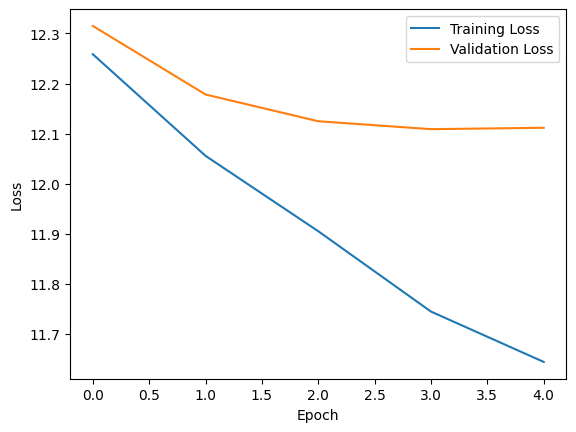

In [48]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(5)], training_loss, label='Training Loss')
plt.plot([i for i in range(5)], val_loss, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


### TESTING AGAINST BASELINES FOR DEV

# XLM

### Model Loading

In [67]:
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
model_name = "xlm-roberta-base"
model_chkpt = "/content/drive/MyDrive/chkptxlm/checkpoint-2595"
model = XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=6)
tokenizer = XLMRobertaTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
# from transformers import AutoTokenizer, AutoModelForMaskedLM

# tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")

# model = AutoModelForMaskedLM.from_pretrained("xlm-roberta-large", num_labels = 6)

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Tokenization

In [68]:
from datasets import Dataset

In [69]:
def tokenize_function(example):
    return tokenizer(
        example["tweet"],
        max_length=512,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )

In [70]:
tokenized_train = Dataset.from_pandas(train_dataset_soft3).map(tokenize_function, batched=True)
tokenized_validation = Dataset.from_pandas(val_dataset_soft3).map(tokenize_function, batched=True)
test_validation = Dataset.from_pandas(test_dataset3).map(tokenize_function, batched=True)

Map:   0%|          | 0/6920 [00:00<?, ? examples/s]

Map:   0%|          | 0/1038 [00:00<?, ? examples/s]

Map:   0%|          | 0/2076 [00:00<?, ? examples/s]

In [71]:
tokenized_datasets = tokenized_train.rename_column("soft_label3", "labels")
tokenized_datasets_train = tokenized_datasets.remove_columns(["tweet", "__index_level_0__"])
tokenized_datasets_train.set_format("torch")


tokenized_datasets = tokenized_validation.rename_column("soft_label3", "labels")
tokenized_datasets_val = tokenized_datasets.remove_columns(["tweet"])
tokenized_datasets_val.set_format("torch")

tokenized_datasets_test = tokenized_test.remove_columns(["tweet"])
tokenized_datasets_test.set_format("torch")

### Training The dataset

In [72]:
from transformers import Trainer
import torch
torch.cuda.empty_cache()

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/chkptxlm",
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-05,
    weight_decay=0.004891290652279793,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch"
)

#with cross entropy loss and label smoothing
def custom_loss_fn(logits, soft_labels3):
    probs = torch.sigmoid(logits)
    # Apply nn.CrossEntropyLoss
    loss = nn.CrossEntropyLoss(reduction="sum",label_smoothing=0.15)(probs, soft_labels3)
    return loss

# Define the trainer for each fold
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = custom_loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss



torch.cuda.empty_cache()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets_train,
    eval_dataset= tokenized_datasets_val
)


In [73]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,12.355000,12.547586
2,12.288600,12.467033
3,12.290600,12.546621
4,12.267800,12.494469
5,12.220800,12.398818


TrainOutput(global_step=4325, training_loss=12.284554281069363, metrics={'train_runtime': 3728.693, 'train_samples_per_second': 9.279, 'train_steps_per_second': 1.16, 'total_flos': 9103969467187200.0, 'train_loss': 12.284554281069363, 'epoch': 5.0})

### Plotting

In [74]:
training_loss = [i["loss"] for i in trainer.state.log_history[:-1:2]]
val_loss = [i["eval_loss"] for i in trainer.state.log_history[1::2]]

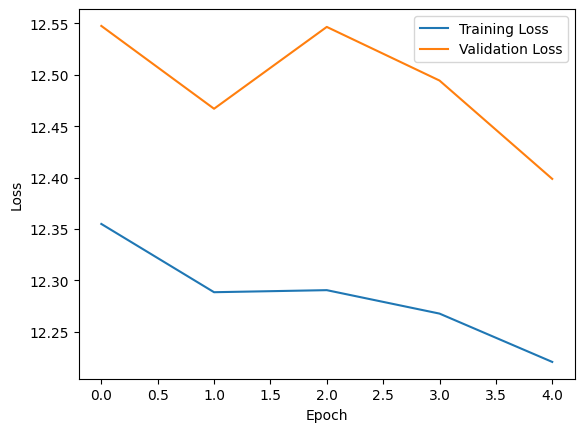

In [75]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(5)], training_loss, label='Training Loss')
plt.plot([i for i in range(5)], val_loss, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Predictions

In [76]:
from scipy.special import expit
from sklearn.metrics import accuracy_score, f1_score

val_predictions_xlm = trainer.predict(tokenized_datasets_val)
val_pred_probabilities_xlm = expit(val_predictions_xlm.predictions)
val_pred_labels_xlm = np.where(val_pred_probabilities_xlm > 0.5, 1, 0)

val_true_labels_xlm = [[1 if value > 0.5 else 0 for value in sublist] for sublist in tokenized_datasets_val["labels"]]


In [77]:
train_predictions_xlm = trainer.predict(tokenized_datasets_train)
train_pred_probabilities_xlm = expit(train_predictions_xlm.predictions)
train_pred_labels_xlm = np.where(train_pred_probabilities_xlm > 0.5, 1, 0)
train_true_labels = [[1 if value > 0.5 else 0 for value in sublist] for sublist in tokenized_datasets_train["labels"]]

In [78]:
val_accuracy_xlm = accuracy_score(val_true_labels_xlm, val_pred_labels_xlm)
val_f1_score_xlm = f1_score(val_true_labels_xlm, val_pred_labels_xlm,average = "weighted")
print("F1 score of our xlm model on dev:", val_f1_score_xlm)
print("Accuracy score our xlm model on dev:", val_accuracy_xlm)

train_accuracy_xlm = accuracy_score(train_true_labels, train_pred_labels_xlm)
train_f1_score_xlm = f1_score(train_true_labels, train_pred_labels_xlm,average = "weighted")
print("F1 score of our xlm model on train:", train_f1_score_xlm)
print("Accuracy score our xlm model on train:", train_accuracy_xlm)

# val_accuracy_xlm = accuracy_score(val_true_labels_xlm, labels_min)
# val_f1_score_xlm = f1_score(val_true_labels_xlm, labels_min,average = "weighted")
# print("F1 score of Min Baseline:", val_f1_score_xlm)
# print("Accuracy score of Min Baseline:", val_accuracy_xlm)

# val_accuracy_xlm = accuracy_score(val_true_labels_xlm, labels_maj)
# val_f1_score_xlm = f1_score(val_true_labels_xlm, labels_maj,average = "weighted")
# print("F1 score of Maj Baseline:", val_f1_score_xlm)
# print("Accuracy score of Maj Baseline:", val_accuracy_xlm)

F1 score of our xlm model on dev: 0.5303626602788577
Accuracy score our xlm model on dev: 0.47784200385356457
F1 score of our xlm model on train: 0.5661947252815445
Accuracy score our xlm model on train: 0.5216763005780347


In [79]:
from scipy.special import expit
test_predictions_xlm = trainer.predict(tokenized_datasets_test)
test_pred_probabilities_xlm = expit(test_predictions_xlm.predictions) #same as sigmoid
test_pred_labels_xlm = np.where(test_pred_probabilities_xlm > 0.5, 1, 0)

In [80]:
classes_labels = ['IDEOLOGICAL-INEQUALITY','MISOGYNY-NON-SEXUAL-VIOLENCE', 'OBJECTIFICATION','STEREOTYPING-DOMINANCE','SEXUAL-VIOLENCE','NO']
def create_results(probabilities, class_labels):
    results = []
    for prob_list in probabilities:
        result_dict = {label: prob for label, prob in zip(class_labels, prob_list)}
        results.append(result_dict)
    return results

test_probs_listxlm = create_results(test_pred_probabilities_xlm.tolist(), classes_labels)
# test_probs_list1

### Output

In [81]:
import json
json_object = {}
json_object = []
for i in range(len(test_probs_listxlm)):
    json_object.append({
        "id": str(tokenized_datasets_test['__index_level_0__'][i].item()),
        "value": test_probs_listxlm[i],
        "test_case": "EXIST2024"
    })
with open("/content/output/task3_soft_fmrs_2.json", "w") as outfile:
    json.dump(json_object, outfile, indent = 4)


In [82]:
labels = []
for row in test_pred_labels_xlm:
    indices = [i for i, val in enumerate(row) if val == 1]
    lst = np.array(labels3)[indices]
    labels.append(lst.tolist())

In [83]:
json_object = {}
json_object = []
for i in range(len(test_probs_list1)):
    json_object.append({
        "id": str(tokenized_datasets_test['__index_level_0__'][i].item()),
        "value": labels[i],
        "test_case": "EXIST2024"
    })
with open("/content/output/task3_hard_fmrs_2.json", "w") as outfile:
    json.dump(json_object, outfile, indent = 2)


### Testing Against Baselines

In [ ]:
# import json
# import os

# def read_file(file_path):
#     labels = []
#     with open(file_path, 'r') as f:
#         data = json.load(f)
#         for i in data:
#           labels.append([v for k,v in i['value'].items()])
#           # break
#             # labels.append([j.value() for j in i["value"]])
#     return labels

# labels_maj = read_file("/content/EXIST2024_dev_task3_majority_class_soft.json")

In [103]:
# import json
# import os

# def read_file(file_path):
#     labels = []
#     with open(file_path, 'r') as f:
#         data = json.load(f)
#         for i in data:
#           labels.append([v for k,v in i['value'].items()])
#           # break
#             # labels.append([j.value() for j in i["value"]])
#     return labels

# labels_min = read_file("/content/EXIST2024_dev_task3_minority_class_soft.json")

# Ensemble

In [85]:
predictions_soft_ensamble_test = (test_pred_probabilities_bert + test_pred_probabilities_xlm)/2
test_pred_labels_ensemble = np.where(predictions_soft_ensamble_test > 0.5, 1, 0)

In [86]:
predictions_soft_ensamble_val = (val_pred_probabilities + val_pred_probabilities_xlm)/2
# test_pred_probabilities_ensem = expit(predictions_soft_ensamble_test.predictions) #same as sigmoid
val_pred_labels_ensemble = np.where(predictions_soft_ensamble_val > 0.5, 1, 0)

In [94]:
predictions_soft_ensamble_train = (train_pred_probabilities_bert + train_pred_probabilities_xlm)/2
# test_pred_probabilities_ensem = expit(predictions_soft_ensamble_test.predictions) #same as sigmoid
train_pred_labels_ensemble = np.where(predictions_soft_ensamble_train > 0.5, 1, 0)

In [87]:
labels = []
for row in test_pred_labels_ensemble:
    indices = [i for i, val in enumerate(row) if val == 1]
    lst = np.array(labels3)[indices]
    labels.append(lst.tolist())

In [88]:
classes_labels = ['IDEOLOGICAL-INEQUALITY','MISOGYNY-NON-SEXUAL-VIOLENCE', 'OBJECTIFICATION','STEREOTYPING-DOMINANCE','SEXUAL-VIOLENCE','NO']
def create_results(probabilities, class_labels):
    results = []
    for prob_list in probabilities:
        result_dict = {label: prob for label, prob in zip(class_labels, prob_list)}
        results.append(result_dict)
    return results

test_probs_list_ensamble = create_results(predictions_soft_ensamble_test.tolist(), classes_labels)
# test_probs_list1

In [89]:
import json
json_object = {}
json_object = []
for i in range(len(test_probs_list_ensamble)):
    json_object.append({
        "id": str(tokenized_datasets_test['__index_level_0__'][i].item()),
        "value": test_probs_listxlm[i],
        "test_case": "EXIST2024"
    })
with open("/content/output/task3_soft_fmrs_3.json", "w") as outfile:
    json.dump(json_object, outfile, indent = 4)


In [90]:
json_object = {}
json_object = []
for i in range(len(test_pred_labels_ensemble)):
    json_object.append({
        "id": str(tokenized_datasets_test['__index_level_0__'][i].item()),
        "value": labels[i],
        "test_case": "EXIST2024"
    })
with open("/content/output/task3_hard_fmrs_3.json", "w") as outfile:
    json.dump(json_object, outfile, indent = 2)

In [97]:
val_accuracy_xlm = accuracy_score(val_true_labels_xlm, val_pred_labels_ensemble)
val_f1_score_xlm = f1_score(val_true_labels_xlm, val_pred_labels_ensemble,average = "weighted")
print("F1 score of our ensamble model (dev):", val_f1_score_xlm)
print("Accuracy score our ensamble model (dev):", val_accuracy_xlm)

F1 score of our ensamble model (dev): 0.5523881534444895
Accuracy score our ensamble model (dev): 0.535645472061657


In [105]:
train_accuracy_xlm = accuracy_score(train_true_labels, train_pred_labels_ensemble)
train_f1_score_xlm = f1_score(val_true_labels_xlm, val_pred_labels_ensemble,average = "weighted")
print("F1 score of our ensamble model (train):", train_f1_score_xlm)
print("Accuracy score our ensamble model (train):", train_accuracy_xlm)

F1 score of our ensamble model (train): 0.5523881534444895
Accuracy score our ensamble model (train): 0.6049132947976879
